______________
Importing necessary libraries and setting global variables

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from scipy.stats import mode
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from models import UnbalancedBagger, UnbalancedBaggerNoSampling
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve

RANDOM_SEED = 12345

In [25]:
original_df = pd.read_csv("datasets/diabetes.csv")


In [26]:
original_df.describe()
#weird that "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI" have zero values, imputate mean values

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [27]:
print("Amount of 0 values:")
print("Glucose: ", len(original_df[original_df["Glucose"] == 0]))
print("BloodPressure: ", len(original_df[original_df["BloodPressure"] == 0]))
print("SkinThickness: ", len(original_df[original_df["SkinThickness"] == 0]))
print("Insulin: ", len(original_df[original_df["Insulin"] == 0]))
print("BMI: ", len(original_df[original_df["BMI"] == 0]))

Amount of 0 values:
Glucose:  5
BloodPressure:  35
SkinThickness:  227
Insulin:  374
BMI:  11


In [28]:
def imputation(data, columns):
    for c in columns:
         if c in data.columns:
             data[c].replace(0, np.nan,inplace=True)
             data[c].fillna(data[c].mean(), inplace=True)
    return data


In [29]:
original_df = imputation(original_df, ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"])

original_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


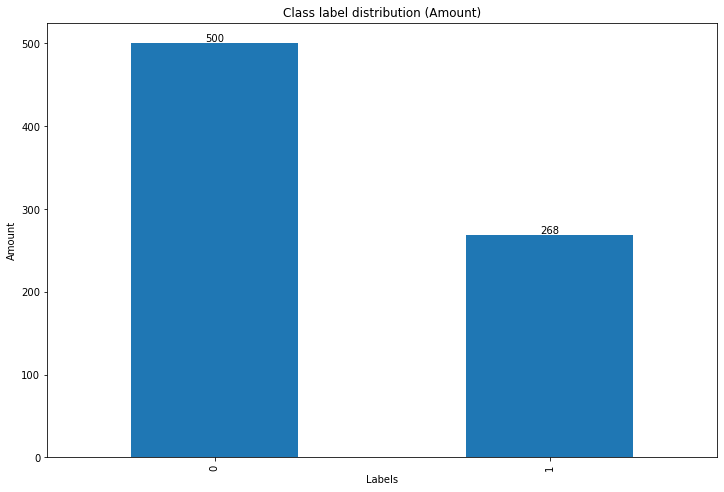

In [30]:
total_labels = original_df.Outcome.value_counts()
x_labels = [0,1]

plt.figure(figsize=(12,8))
ax = total_labels.plot(kind='bar')
ax.set_title('Class label distribution (Amount)')
ax.set_xlabel('Labels')
ax.set_ylabel('Amount')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect,lbl in zip(rects, total_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height
            , lbl, ha='center', va='bottom')

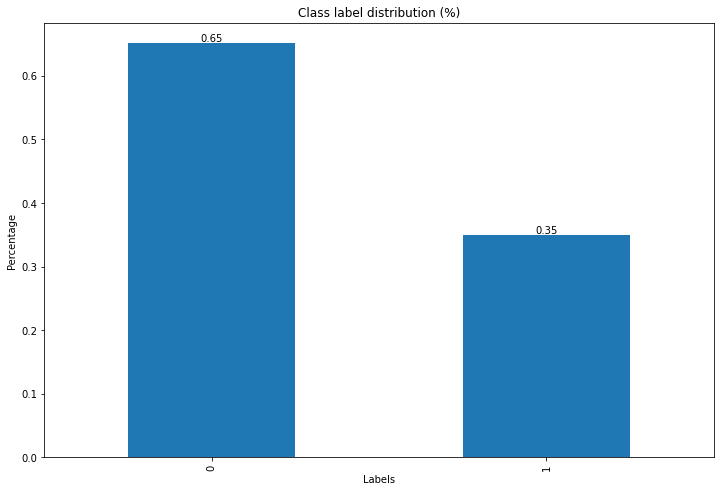

In [31]:
x_labels = [0,1]
total_labels_percentage = original_df.Outcome.value_counts()/len(original_df)

plt.figure(figsize=(12,8))
ax = total_labels_percentage.plot(kind='bar')
ax.set_title('Class label distribution (%)')
ax.set_xlabel('Labels')
ax.set_ylabel('Percentage')
ax.set_xticklabels(x_labels)

rects = ax.patches
labels = []

for lbl in total_labels_percentage:
    labels.append("{0:.2f}".format(lbl))

for rect,lbl in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height
            , lbl, ha='center', va='bottom')

In [38]:
#we can now split attributes and class label
X = original_df.drop('Outcome', axis=1)
y = original_df.Outcome

X.describe()

#data_standardized used for SVC
scaler = StandardScaler()
data_standardized = scaler.fit_transform(X)
data_standardized = pd.DataFrame(data_standardized,columns=X.columns)

In [ ]:
X_train,X_test,y_train,y_test, = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

#standardized split for SVC
X_train_svc,X_test_svc,y_train_svc,y_test_svc, = train_test_split(data_standardized, y, test_size=0.3, random_state=RANDOM_SEED)

In [34]:
param_grid_svc = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf', 'poly']},
 ]

param_grid_dt = [
    {'splitter' : ['best', 'random'],
     'min_samples_split':[2,5,10],
     'min_samples_leaf':[1,5,10],
     'min_weight_fraction_leaf':[0,0.05, 0.1, 0.15, 0.2]
     }
]

dtc = DecisionTreeClassifier(random_state=RANDOM_SEED)
svc = SVC(random_state=RANDOM_SEED, probability=True)

#Methods for sampling
ros = RandomOverSampler(random_state=RANDOM_SEED)
rus = RandomUnderSampler(random_state=RANDOM_SEED)
smote = SMOTE(random_state=RANDOM_SEED, sampling_strategy='minority')

search_dtc = GridSearchCV(dtc, param_grid_dt, cv=10, scoring='roc_auc')
search_svc = GridSearchCV(svc, param_grid_svc, cv=10, scoring='roc_auc')

In [35]:
def smote_technique(X,y):
    x_sample, y_sample = smote.fit_sample(X, y)
    return x_sample,y_sample

def random_oversampling_technique(X,y):
    x_sample, y_sample = ros.fit_sample(X, y)
    return x_sample,y_sample

def random_undersampling_technique(X,y):
    x_sample, y_sample = rus.fit_sample(X, y)
    return x_sample,y_sample

Original data
Validation
Decision tree:
0.7776033834586467
DecisionTreeClassifier(min_weight_fraction_leaf=0.05, random_state=12345)
SVC:
0.8199679345422378
SVC(C=100, gamma=0.001, probability=True, random_state=12345)

Test
Decision tree:
AUC:  0.7449280388416855
SVC:
AUC:  0.7560256632564591


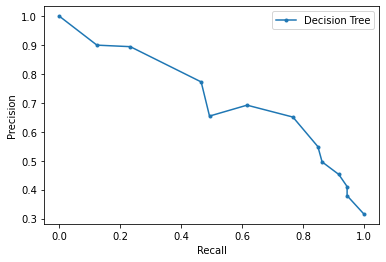

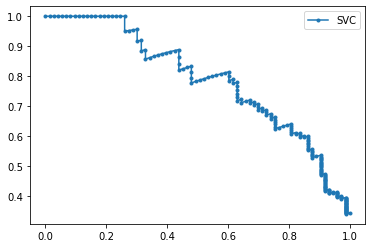

In [43]:
#Train on original data
print("Original data")

print('Validation')
print('Decision tree:')
search_dtc.fit(X_train, y_train)
print(search_dtc.best_score_)
print(search_dtc.best_estimator_)

print('SVC:')
search_svc.fit(X_train_svc, y_train_svc)
print(search_svc.best_score_)
print(search_svc.best_estimator_)

print('\nTest')
print('Decision tree:')
print('AUC: ',roc_auc_score(y_test,search_dtc.best_estimator_.predict(X_test)))

probs = search_dtc.best_estimator_.predict_proba(X_test)
pos_probs = probs[:,1]

prec, recall, thres = precision_recall_curve(y_test, pos_probs)
plt.plot(recall, prec, marker = '.', label='Decision Tree')
plt.xlabel('Recall')
plt.ylabel('Precision')

print('SVC:')
print('AUC: ',roc_auc_score(y_test_svc,search_svc.best_estimator_.predict(X_test_svc)))
probs = search_svc.best_estimator_.predict_proba(X_test_svc)
pos_probs = probs[:,1]
prec, recall, thres = precision_recall_curve(y_test_svc, pos_probs)
plt.plot(recall, prec, marker = '.', label='SVC')

plt.legend()
plt.show()

In [65]:
def create_AUPRC_values(classifier, X_test, y_true):
    probs = classifier.predict_proba(X_test)
    pos_probs = probs[:,1]
    prec,recall,_ = precision_recall_curve(y_true, pos_probs)
    return prec,recall

In [66]:
def create_AUPRC_curves(list_of_rpl):
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    for recall, prec, lbl in list_of_rpl:
        plt.plot(recall,prec,marker='.', label=lbl)
        plt.legend()

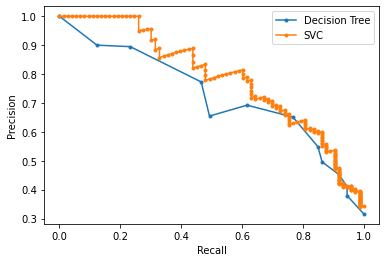

In [68]:
list_of_rpl = []

classifier = search_dtc.best_estimator_
prec, recall = create_AUPRC_values(classifier,X_test, y_test)
list_of_rpl.append([recall, prec,'Decision Tree'])

classifier = search_svc.best_estimator_
prec, recall = create_AUPRC_values(classifier,X_test_svc, y_test_svc)
list_of_rpl.append([recall,prec,'SVC'])

create_AUPRC_curves(list_of_rpl)

plt.show()

In [ ]:
#Train on SMOTE
sampled_dtc_x, sampled_dtc_y = smote_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = smote_technique(X_train_svc,y_train_svc)

search_dtc.fit(sampled_dtc_x, sampled_dtc_y)
search_svc.fit(sampled_svc_x, sampled_svc_y)

print('Validation')
print('SMOTE')
print('Decision tree:')
print(search_dtc.best_score_)
print(search_dtc.best_estimator_)

print('SVC:')
print(search_svc.best_score_)
print(search_svc.best_estimator_)

print('\nTest')
print('Decision tree:')
print(roc_auc_score(y_test,search_dtc.best_estimator_.predict(X_test)))
print('SVC:')
print(roc_auc_score(y_test_svc,search_svc.best_estimator_.predict(X_test_svc)))

In [ ]:
#Train on random oversampling
sampled_dtc_x, sampled_dtc_y = random_oversampling_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = random_oversampling_technique(X_train_svc,y_train_svc)

search_dtc.fit(sampled_dtc_x, sampled_dtc_y)
search_svc.fit(sampled_svc_x, sampled_svc_y)

print('Validation')
print('Random Oversampling')
print('Decision tree:')
print(search_dtc.best_score_)
print(search_dtc.best_estimator_)

print('SVC:')
print(search_svc.best_score_)
print(search_svc.best_estimator_)

print('\nTest')
print('Decision tree:')
print(roc_auc_score(y_test,search_dtc.best_estimator_.predict(X_test)))
print('SVC:')
print(roc_auc_score(y_test_svc,search_svc.best_estimator_.predict(X_test_svc)))

In [ ]:
#Train on random undersampling
sampled_dtc_x, sampled_dtc_y = random_undersampling_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = random_undersampling_technique(X_train_svc,y_train_svc)

search_dtc.fit(sampled_dtc_x, sampled_dtc_y)
search_svc.fit(sampled_svc_x, sampled_svc_y)

print('Validation')
print('Random Undersampling')
print('Decision tree:')
print(search_dtc.best_score_)
print(search_dtc.best_estimator_)

print('SVC:')
print(search_svc.best_score_)
print(search_svc.best_estimator_)

print('\nTest')
print('Decision tree:')
print(roc_auc_score(y_test,search_dtc.best_estimator_.predict(X_test)))
print('SVC:')
print(roc_auc_score(y_test_svc,search_svc.best_estimator_.predict(X_test_svc)))

In [ ]:
def print_test_output(predictions_dt, predictions_svc, true_pred_dt, true_pred_svc):
    print('Test results:')
    print('Decision Tree:')
    print('AUC: ', roc_auc_score(true_pred_dt, predictions_dt))
    print('AUPRC: ', average_precision_score(true_pred_dt, predictions_dt))
    print('Recall: ', roc_auc_score(true_pred_dt, predictions_dt))
    print('Precision: ', roc_auc_score(true_pred_dt, predictions_dt))

    print('\nSVC:')
    print('AUC: ', roc_auc_score(true_pred_svc, predictions_svc))
    print('AUPRC: ', average_precision_score(true_pred_svc, predictions_svc))
    print('Recall: ', roc_auc_score(true_pred_svc, predictions_svc))
    print('Precision: ', roc_auc_score(true_pred_svc, predictions_svc))

In [ ]:
#new method, using smote, ros, rus
sampling_techniques = [smote, ros, rus]
svc = SVC(C=1000, gamma=0.001, random_state=12345, probability=True)
dtc = DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,random_state=12345)

classifier_dtc = UnbalancedBagger.unbalanced_bagger(X_train, y_train, 10, sampling_techniques,base_estimator=dtc,random_seed=RANDOM_SEED)
classifier_svc = UnbalancedBagger.unbalanced_bagger(X_train_svc, y_train_svc, 10, sampling_techniques,base_estimator=svc,random_seed=RANDOM_SEED)

y_score_dtc = classifier_dtc(X_test)
y_score_svc = classifier_svc(X_test_svc)

print_test_output(predictions_dt=y_score_dtc, predictions_svc=y_score_svc,true_pred_dt=y_test, true_pred_svc=y_test_svc)

In [ ]:
print('\nTest')
print('Decision tree:')
print(roc_auc_score(y_test,y_score_dtc))
print('SVC:')
print(roc_auc_score(y_test_svc,y_score_svc))

In [ ]:
#bagging no sampling
svc = SVC(C=1000, gamma=0.001, random_state=12345,probability=True)
dtc = DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,random_state=12345)

classifier_dtc = UnbalancedBaggerNoSampling.unbalanced_bagger_no_sampling(X_train, y_train, 10, base_estimator=dtc,random_seed=RANDOM_SEED)
classifier_svc = UnbalancedBaggerNoSampling.unbalanced_bagger_no_sampling(X_train_svc, y_train_svc, 10, base_estimator=svc,random_seed=RANDOM_SEED)

y_score_dtc = classifier_dtc(X_test)
y_score_svc = classifier_svc(X_test_svc)

print('\nTest')
print('Decision tree:')
print(roc_auc_score(y_test,y_score_dtc))
print('SVC:')
print(roc_auc_score(y_test_svc,y_score_svc))

In [ ]:
#testing
sampling_techniques = [smote, ros, rus]
dtc = DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,random_state=12345)
svc = SVC(probability=True)
#predict, predict_proba = UnbalancedBagger.unbalanced_bagger(X_train, y_train, 10, sampling_techniques,base_estimator=dtc,random_seed=RANDOM_SEED)
predict_svc, predict_proba_svc = UnbalancedBagger.unbalanced_bagger(X_train_svc, y_train_svc, 10, sampling_techniques,base_estimator=svc,random_seed=RANDOM_SEED)

#y_test_score = predict_proba(X_test)
y_test_score = predict_proba_svc(X_test_svc)

print(y_test_score)